<a href="https://colab.research.google.com/github/h5ng/influence_functions/blob/master/kmeans_with_influence_functions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%tensorflow_version 1.x

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

num_points = 2000
x_data = []
for i in range(num_points):
  if np.random.random() < 0.5:
    x_data.append([ np.random.normal(0.0, 0.9),
                   np.random.normal(0.0, 0.9)])
  else:
    x_data.append([np.random.normal(3.0, 0.5),
                   np.random.normal(1.0, 0.5)])

/usr/local/lib/python3.6/dist-packages/seaborn/regression.py:573: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


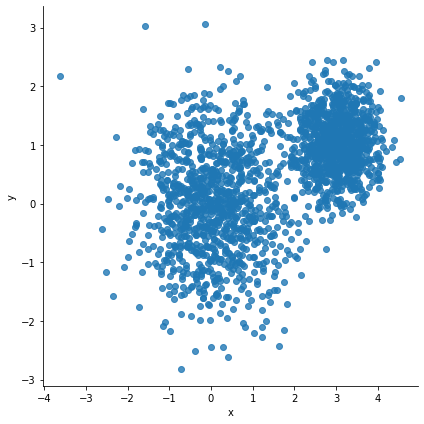

In [93]:
df = pd.DataFrame({'x': [v[0] for v in x_data],
                   'y': [v[1] for v in x_data]})

sns.lmplot('x', 'y', data=df, fit_reg=False, size=6)
plt.show()

In [0]:
import tensorflow as tf
import numpy as np

k = 4
vectors = tf.constant(x_data)
initial_centroids = x_data[:4]
# centroids = tf.Variable(tf.slice(tf.random_shuffle(vectors), [0, 0], [k, -1]))
centroids = tf.Variable(initial_centroids)

expanded_vectors = tf.expand_dims(vectors, 0)
expanded_centroids = tf.expand_dims(centroids, 1)

ph_vectors = tf.placeholder(tf.float32, shape=(1, None, 2))
ph_centroids = tf.placeholder(tf.float32, shape=(None, 1, 2))

In [95]:
diff = tf.subtract(ph_vectors, ph_centroids)
sqr = tf.square(diff)
distances = tf.reduce_sum(sqr, 2)
assignments = tf.argmin(distances, 0)

print(diff.shape)
print(sqr.shape)
print(distances.shape)
print(assignments.shape)

(?, ?, 2)
(?, ?, 2)
(?, ?)
(?,)


In [0]:
means = tf.concat(
    [tf.reduce_mean(
        tf.gather(vectors,
                  tf.reshape(tf.where(tf.equal(assignments, c)), [1, -1])
                  ), 1) for c in range(k)], 0)

In [0]:
update_centroids = tf.assign(centroids, means)

In [0]:
init_op = tf.global_variables_initializer()

In [0]:
sess = tf.Session()
sess.run(init_op)

num_steps = 100
for stem in range(num_steps):
  _, centroid_values, assignment_values = sess.run(
      [update_centroids, centroids, assignments],
      feed_dict={ph_vectors: np.expand_dims(x_data, axis=0),
                 ph_centroids: np.expand_dims(initial_centroids, axis=1)})

In [100]:
print(centroid_values)

[[-0.06084753  0.421704  ]
 [ 0.9890684  -0.9297283 ]
 [-0.9106415  -0.95731634]
 [ 2.9890518   1.045235  ]]


/usr/local/lib/python3.6/dist-packages/seaborn/regression.py:573: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


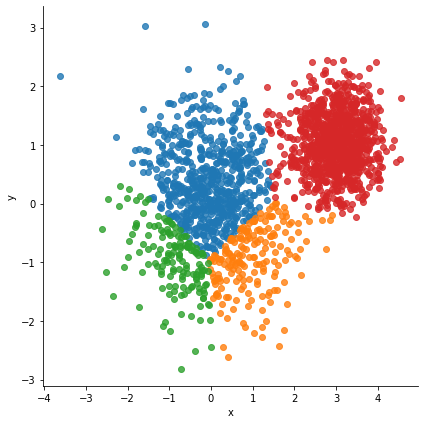

In [101]:
data = {'x': [], 'y': [], 'c': []}
for i in range(len(assignment_values)):
  data['x'].append(x_data[i][0])
  data['y'].append(x_data[i][1])
  data['c'].append(assignment_values[i])

df = pd.DataFrame(data)
sns.lmplot('x', 'y', data=df, fit_reg=False, size=6, hue='c',
           legend=False)

plt.show()

In [0]:
train_grad = tf.gradients(distances, [ph_centroids])
train_hessian = tf.hessians(distances, [ph_centroids])

In [103]:
TARGET_CENTROID_NUMBER = 2
INFLUENCE_COUNT = 10

target_centroid = np.expand_dims(centroid_values[TARGET_CENTROID_NUMBER], axis=0)
target_centroid = np.expand_dims(target_centroid, axis=0)

print(target_centroid.shape)

(1, 1, 2)


In [0]:
influences = []
for i in range(len(x_data)):
# for i in range(1):
  target_vector = np.expand_dims(x_data[i], axis=0)
  target_vector = np.expand_dims(target_vector, axis=0)

  feed_dict = {ph_vectors: target_vector,
               ph_centroids: target_centroid}

  hess = sess.run(train_hessian, feed_dict=feed_dict)
  hess_a = hess[0][0][0][0][0]
  hess_b = hess[0][0][0][1][0]
  hess = np.concatenate((hess_a, hess_b), axis=0)
  
  inv_hess = np.linalg.inv(hess)
  
  grad = sess.run(train_grad, feed_dict=feed_dict)
  grad = grad[0][0][0]
  
  influences.append((i, -np.linalg.norm(inv_hess @ grad, ord=2)))

influences = sorted(influences, key=lambda x: x[1])

harmful_x = influences[:INFLUENCE_COUNT]
helpful_x = influences[-INFLUENCE_COUNT:]

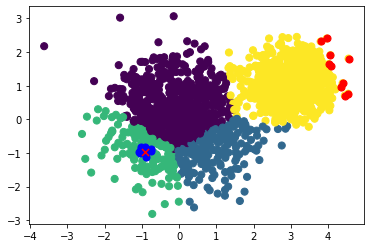

In [105]:
%matplotlib inline
import matplotlib.pyplot as plt

x_data_list = list(x_data)
data = {
  'x': [x_data_list[i][0] for i in range(len(x_data_list))],
  'y': [x_data_list[i][1] for i in range(len(x_data_list))],
  'c': assignment_values
}

harmful_data = {
    'x': [x_data_list[harmful_x[i][0]][0] for i in range(len(harmful_x))],
    'y': [x_data_list[harmful_x[i][0]][1] for i in range(len(harmful_x))],
    'c': 'r'
}

helpful_data = {
    'x': [x_data_list[helpful_x[i][0]][0] for i in range(len(helpful_x))],
    'y': [x_data_list[helpful_x[i][0]][1] for i in range(len(helpful_x))],
    'c': 'b'
}

centroid_data = {
    'x': centroid_values[TARGET_CENTROID_NUMBER][0],
    'y': centroid_values[TARGET_CENTROID_NUMBER][1],
    'c': 'r'
}

plt.scatter('x', 'y', c='c', s=50, data=data)
plt.scatter('x', 'y', c='c', s=50, data=harmful_data)
plt.scatter('x', 'y', c='c', s=50, data=helpful_data)
plt.scatter('x', 'y', c='c', s=50, marker='x', data=centroid_data)

plt.show()